<b>Submission by Group 41 Members:</b>

<u>2019AD04026 - Ankit Gupta</u>

<u>2019AD04027 - Hitesh Gupta</u>

<u>2019AD04031 - Aditya Mehta</u>

Prepare python notebook (recommended- use Google Colab) to build, train and evaluate model (tensorflow or tensorflow.keras library recommended). Read the instructions carefully.

<b>Question: Image Captioning </b>: Image Captioning is the process of generating textual description of an image. It uses
both Natural Language Processing and Computer Vision to generate the captions. The dataset will be in the form [image
→ captions]. The dataset consists of input images and their corresponding output captions.

<b>Encoder</b>
The Convolutional Neural Network(CNN) can be thought of as an encoder. The input image is given to CNN to extract
the features. The last hidden state of the CNN is connected to the Decoder.

<b>Decoder</b>
The Decoder is a Recurrent Neural Network(RNN) which does language modelling up

In [1]:
#Mounting Google Drive - where captions pickle and image data zip file is stored.
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


**1. Import Libraries/Dataset**
> a. Import the required libraries<br>
> b. Check the GPU available (recommended- use free GPU provided by Google Colab).

In [19]:
# a. Import the required libraries

import pandas as pd
import pickle
import os, re
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.models import Model

pd.set_option("display.max_columns", 999)

#Random seed
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

FILE_PATH = "/content/gdrive/MyDrive/bits/DL-assignment"
IMAGE_DATA_PATH = "/content/gdrive/MyDrive/bits/DL-assignment/Image_captioning_Dataset.zip"
CAPTIONS_PATH = os.path.join(FILE_PATH, "set_1.pkl")

In [14]:
# b. Check the GPU available (recommended- use free GPU provided by Google Colab).

print("============== GPU Config: ============")
print(device_lib.list_local_devices()[1])

============== GPU Config: ============
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11344216064
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7916137744600906108
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"



In [15]:
# Unzipping the downloaded dataset

import zipfile

with zipfile.ZipFile(IMAGE_DATA_PATH, 'r') as zip_ref:
    zip_ref.extractall(os.curdir)

In [16]:
# Setting the image data folder

IMAGE_DATA_FOLDER = "Flicker8k_Dataset/"

**2. Data Visualization and augmentation (3 mark)**<br>
> 1. Read the pickle file. Pickle file contains the image id and the text associated with the image.
- Eg: '319847657_2c40e14113.jpg#0\tA girl in a purple shirt hold a pillow .Each image can have multiple captions.
 - 319847657_2c40e14113.jpg -> image name
 - #0 -> Caption ID
 - \t -> separator between Image name and Image Caption

> Image dataset Folder : https://drive.google.com/file/d/1-mPKMpphaKqtT26ZzbR5hCHGedkNyAf1/view?usp=sharing

> a. Plot at least two samples and their captions (use matplotlib/seaborn/any other library).<br>
> b. Bring the train and test data in the required format.

In [22]:
# Printing the sample data

pd.set_option("max_colwidth", 123)
objects = pd.read_pickle(CAPTIONS_PATH)
df = pd.DataFrame(objects)
df.head()

,0
0,"2089122314_40d5739aef.jpg#3\tA fluffy , tri-colored dog be run down a road with a paper in its mouth ."
1,"1295671216_cde1b9c9d1.jpg#0\tA crowd of person be stand together on a sidewalk , while one man be take a picture ."
2,"3183195185_cd0ff994a1.jpg#4\tThe man and boy sit on the ground , next to a rocky wall ."
3,2949353587_64c54e9589.jpg#1\tA brown dog be play with a white fluffy stuff animal .
4,361092202_3d70144ebd.jpg#2\tA man hike with a large backpack and two pole near a collection of pointy white rock .


In [23]:
# Splitting the rows in respective caption, img_nm columns of a dataframe

raw_df = pd.DataFrame()
for i, row in enumerate(objects):
  img_dict = {}
  img_dict['img_nm'] = str(row).split('#')[0]
  img_dict['caption_id'] = str(row).split('#')[1].split('\t')[0]
  img_dict['img_caption'] = row.split('\t')[1]
  raw_df =raw_df.append(img_dict, ignore_index=True)
raw_df.head()

,caption_id,img_caption,img_nm
0,3,"A fluffy , tri-colored dog be run down a road with a paper in its mouth .",2089122314_40d5739aef.jpg
1,0,"A crowd of person be stand together on a sidewalk , while one man be take a picture .",1295671216_cde1b9c9d1.jpg
2,4,"The man and boy sit on the ground , next to a rocky wall .",3183195185_cd0ff994a1.jpg
3,1,A brown dog be play with a white fluffy stuff animal .,2949353587_64c54e9589.jpg
4,2,A man hike with a large backpack and two pole near a collection of pointy white rock .,361092202_3d70144ebd.jpg


In [25]:
raw_df.drop(raw_df[raw_df.img_nm == '2258277193_586949ec62.jpg.1'].index, inplace=True)

In [24]:
raw_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   caption_id   25000 non-null  object
 1   img_caption  25000 non-null  object
 2   img_nm       25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [27]:
print(len(raw_df.img_nm.unique()))
print(len(os.listdir(IMAGE_DATA_FOLDER)))

8032
8091


**2 a. Plot at least two samples and their captions (use matplotlib/seaborn/any other library).**

In [32]:
def print_sample_imgs(img_dir, pics, nrows, ncols, nimages, df):
  nrows = nrows
  ncols = ncols

  # Index for iterating over images
  pic_index = 0
  # Set up matplotlib fig, and size it to fit 4x4 pics
  fig = plt.gcf()
  fig.set_size_inches(ncols * 6, nrows * 3)

  print("          ======================================================")
  print("          ============== Printing Sample images ================")
  print("          ======================================================")
  j = 1
  for i, img_nm in enumerate(pics):
    if i < nimages:
      # print ("printing {} , image :{}".format(i, img_nm))
      caption = list(df[df['img_nm'] == img_nm]['img_caption'])[0]
      just_img_nm = img_nm.split(sep='.')[0]
      # Set up subplot; subplot indices start at 1
      sp = plt.subplot(nrows, ncols, j)
      sp.axis('Off') # Don't show axes (or gridlines)
      sp.set_title("Img # "+ str(i+1) + " - Caption :" +caption, loc='center')
      raw_img_nm = img_dir + '/' + img_nm
      img = mpimg.imread(raw_img_nm)
      plt.imshow(img)

      j = j + 1
    else:
      break
  plt.show()

          ============== Printing Sample images ================


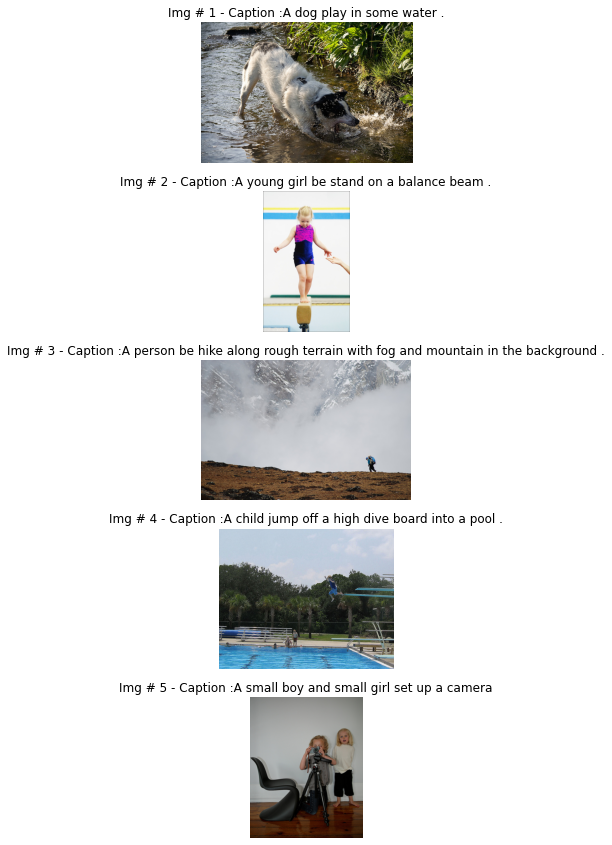

In [33]:
print_sample_imgs(IMAGE_DATA_FOLDER, os.listdir(IMAGE_DATA_FOLDER), nrows=5, ncols=1, nimages=5, df=raw_df)

<b> 2 b. Bring the train and test data in the required format. </b><br>
- Data Preparation

In [34]:
# extrat Features
def extract_features(directory):
    model = ResNet50()

    #remove last layer
    model.layers.pop()
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)    
    print(model.summary())
    
    features = dict()    
    for i, name in enumerate(os.listdir(directory)):
        
        # load and image
        filename = directory + '/' + name
        image = load_img(filename , target_size=(224 , 224))        
        image = img_to_array(image)        
        image = image.reshape((1 , image.shape[0] , image.shape[1] ,image.shape[2]))        
        image = preprocess_input(image)        
        feature = model.predict(image , verbose = 0)
        
        # get image id
        if (name == '2258277193_586949ec62.jpg.1'):
          print(i, name)
          print ('fixing strange image id :',name, name.split(".")[0])
          image_id = '2258277193_586949ec62'
        else:
          image_id = name.split(".")[0]
        
        # store features
        features[image_id] = feature
        
        # print(i, name)
    print("----------------------------------")
    print("Features extraction complete...!!!")
    print("----------------------------------")
    return features

**3. Model Building (7 mark)**<br>
- a. Use Pretrained Resnet-50 model trained on ImageNet dataset (available publicly on google) for image feature extraction.
- b. Create 4 layered LSTM layer model and other relevant layers for image caption generation.
- c. Add L2 regularization to all the LSTM layers.
- d. Add one layer of dropout at the appropriate position and give reasons.
- e. Choose the appropriate activation function for all the layers.
- f. Print the model summary.

3a. Use Pretrained Resnet-50 model trained on ImageNet dataset (available publicly on google) for image feature extraction.

In [14]:
directory = 'Flicker8k_Dataset'
features = extract_features(directory)
print('extracted features :',len(features))
pickle.dump(features , open('features.pkl' , 'wb'))

102973440/102967424 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 25,636,712
Trainable params: 25,583,592
Non-trainable params: 53,120
__________________________________________________________________________________________________
None
extracted features : 8091


*Create* Vocabulary from Images

In [42]:
# Cleaning captions text - Removing punctuations and lemmatizing

lemma = WordNetLemmatizer()

def load_decriptions(doc):
    mapping = dict()
    for i in range(len(doc)):
        image_id = doc['img_nm'][i]
        image_desc = doc['img_caption'][i]        
        if image_id not in mapping:
            mapping[image_id] = list()        
        mapping[image_id].append(image_desc)        
    return mapping

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)    
    # tokenize the words
    desc = desc.split()
    # convert to lower case
    desc = [token.lower() for token in desc]
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

In [43]:
# convert loaded descriptions into vocablury
def to_vocabluary(desc):
    all_desc = set()
    
    for key in desc.keys():
        [all_desc.update(d.split()) for d in desc[key]]
        
    return all_desc

def save_descriptions(desc , filename):
    lines = list()
    
    for key , desc_list in desc.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(filename , 'w')
    file.write(data)
    file.close()

In [44]:
raw_df.head()

,caption_id,img_caption,img_nm
0,3,"A fluffy , tri-colored dog be run down a road with a paper in its mouth .",2089122314_40d5739aef.jpg
1,0,"A crowd of person be stand together on a sidewalk , while one man be take a picture .",1295671216_cde1b9c9d1.jpg
2,4,"The man and boy sit on the ground , next to a rocky wall .",3183195185_cd0ff994a1.jpg
3,1,A brown dog be play with a white fluffy stuff animal .,2949353587_64c54e9589.jpg
4,2,A man hike with a large backpack and two pole near a collection of pointy white rock .,361092202_3d70144ebd.jpg


In [48]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [49]:
raw_df['img_caption'] = raw_df['img_caption'].apply(lambda x : clean_text(str(x)))

In [50]:
raw_df.reset_index(drop=True, inplace=True)

In [51]:
img_caption_map = load_decriptions(raw_df)

In [52]:
vocabulary = to_vocabluary(img_caption_map)

In [53]:
len(vocabulary)

5387

In [54]:
save_descriptions(img_caption_map , 'descriptions.txt')

Train set

In [55]:
from pickle import load


In [56]:
# loading the doc
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text

# this function is used for to get train image description from our dataset

def load_clean_descriptions(filename , dataset):
    doc = load_doc(filename)
    desc = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id , image_desc = tokens[0] , tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in desc:
                desc[image_id] = list()
            
            # we add two tage at start and at end of the descitpion to identify to start and 
            # end of desc.
            desc1 = 'startseq '+ ' '.join(image_desc)+ ' endseq'
            desc[image_id].append(desc1)
            
    return desc


# laod photo features
def load_photo_features(filename , dataset):
    all_features = pickle.load(open(filename,'rb'))
    features = {k+'.jpg' : all_features[k] for k in dataset}
    # features={}
    # for k in dataset:
      # if k in all_features.keys():
        # features[k+'.jpg'] = all_features[k]
      # else:
        # pass
    return features

In [57]:
raw_df.columns

Index(['caption_id', 'img_caption', 'img_nm'], dtype='object')

<b> Splitting data for Train set</b>

In [59]:
train = set(raw_df['img_nm'][:10000])
print('len of train image',len(train))

len of train image 6146


In [60]:
# traininset makinng and set startseq and endseq tag in descriptions
train_descriptions = load_clean_descriptions('descriptions.txt' , train)

In [61]:
print('Length of Train captions :' , len(train_descriptions))

Length of Train captions : 6146


In [62]:
train = pd.DataFrame(train)
train2 = train[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [63]:
# train features means feautures from training images
train_features = load_photo_features('features.pkl' , train2)
print('Total photos for training :',len(train_features))

Total photos for training : 6146


In [64]:
# convert dictonary to lis descriptions

def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

# fit tokenizer on descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [65]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('vocab size' , vocab_size)

vocab size 4919


In [66]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [67]:
# calculate the length with most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max([len(line.split())for line in lines])
    
# create sequences of images,input sequences and output sequences
def create_sequences(tokenizer , max_length , desc_list , photo):
    X1 , X2 , y = list() , list() , list()
    
    for desc in desc_list:
        # convert words to number value
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            
            in_seq , output_seq = seq[:i] , seq[i]
            in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
            output_seq = to_categorical([output_seq] , num_classes = vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(output_seq)
            
    return np.array(X1) , np.array(X2) , np.array(y)

In [68]:
from keras.models import Model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout
from keras.layers.merge import add
from keras.callbacks import EarlyStopping

<b>3b. Create 4 layered LSTM layer model and other relevant layers for image caption generation.</b><br>
<b>3c. Add L2 regularization to all the LSTM layers.</b>

In [69]:
def define_Model(vocab_size , max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(1000 , ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(256 , activation = 'relu')(fe3)
    fe5 = Dense(128 , activation = 'relu')(fe4)
    fe6 = Dense(64 , activation = 'relu')(fe5)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size,512,mask_zero=True )(inputs2) # mask_zero = ignore padding
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256 , return_sequences=True)(se2)
    se4 = Dropout(0.5)(se3)
    se5 = LSTM(128, return_sequences=True)(se4)
    se6 = Dropout(0.5)(se5)
    se7 = LSTM(64, return_sequences=True)(se6)
    se8 = Dropout(0.5)(se7)
    se9 = LSTM(64)(se8)
    
    
    #decoder Model
    decoder1 = add([fe6 , se9])
    decoder2 = Dense(128 , activation='relu')(decoder1)
    decoder3 = Dense(256 , activation='relu')(decoder2)
    decoder4 = Dense(512 , activation='relu')(decoder3)
    outputs = Dense(vocab_size , activation='softmax')(decoder4)
    
    # combine both image and text
    model = Model([inputs1 , inputs2] , outputs)
    model.compile(loss='categorical_crossentropy' , optimizer = 'adam', metrics=["acc"])
    
    # summary
    print(model.summary())
    
    return model

<b>3d. Add one layer of dropout at the appropriate position and give reasons.</b><br><br>
<b><u>Reason </u></b>: Dropout is choosen at all LSTM layers as that is giving us best accuracy with limited epochs (due to free GPU restrictions)

<b>3e. Choose the appropriate activation function for all the layers.</b>
<br>
- RELU activation is used for DNN in convolution part of the network.
- For the sequence model part, default LSTM Sigmoid activation is used. GPU works best with the default.

<b>3f. Print the model summary.</br>
<br>
- Model summary is printed upon start of Model training  below 

<b>4. Model Compilation (1 mark)</b>
<br>
<u>define_model</u> method has compilation part where in we have used 
- loss='categorical_crossentropy' | As this is multi label scenario
- optimizer = 'adam' | As this is adaptive momentum optimizer, which helps to converge fast by adapting the convergence direction.

In [70]:
# below code progressivly load the code in batches
def data_generator(descriptions , photos , tokenizer , max_length):
    while 1:
        for key , desc_list in descriptions.items():
            photo = photos[key][0]
            in_img , in_seq , out_seq = create_sequences(tokenizer , max_length , desc_list , photo)
            in_final_seq = [in_img , in_seq]
            yield (in_final_seq, out_seq)

In [72]:
print('Training data Length     :', len(train))
print('Training captions length :',len(train_descriptions))
print('Training photos #        :',len(train_features))
print('Vocabulary size          :',vocab_size)
max_len = max_length(train_descriptions)
print('Caption - Max length     :', max_len)

Training data Length     : 6146
Training captions length : 6146
Training photos #        : 6146
Vocabulary size          : 4919
Caption - Max length     : 34


In [73]:
from keras.models import load_model

<b>5. Model Training (1 mark)</b><br>
- a. Train the model for an appropriate number of epochs. Print the train and validation loss for each epoch. Use the appropriate
batch size.
- b. Plot the loss and accuracy history graphs for both train and validation set. Print the total time taken for training.

In [46]:
model = define_Model(vocab_size , max_len)
epochs = 5
steps = len(train_descriptions)

for i in range(epochs):
    generator = data_generator(train_descriptions , train_features , tokenizer , max_len)
    # model.fit_generator()
    model.fit_generator(generator, epochs = 1, steps_per_epoch = steps, verbose = 1)
    
    model.save('model_'+ str(i+1) + '.h5')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 512)      2518528     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 34, 512)      0           embedding[0][0]                  
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 1000)]       0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


6146/6146 [==============================] - 2157s 347ms/step - loss: 4.7647


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


6146/6146 [==============================] - 2116s 344ms/step - loss: 3.3334


<b>Bleu Score</b> (Bilingual Evaluation Understudy) For Model Evalution

In [74]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word

In [75]:
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [76]:
from nltk.translate.bleu_score import corpus_bleu

In [77]:
def evaluate_model(model , desciptions , photos , tokenizer , max_length):
    actual , predicted = list() , list()
    
    for key , desc_list in desciptions.items():
        generated_desc = generate_desc(model , tokenizer , photos[key] , max_length)
        
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(generated_desc.split())
    
    print('Bleu_Score -1 = %f'%corpus_bleu(actual , predicted , weights=(1,0,0,0)))
    
    print('Bleu_Score -2 = %f'%corpus_bleu(actual , predicted , weights=(0.5,0.5,0,0)))
    
    print('Bleu_Score -3 = %f'%corpus_bleu(actual , predicted , weights=(0.33,0.33,0.33,0))) 
    
    print('Bleu_Score -4 = %f'%corpus_bleu(actual , predicted , weights=(0.25,0.25,0.25,0.25)))

**Model Predicting**

In [79]:
test = set(raw_df['img_nm'][10001:])
test_descriptions = load_clean_descriptions('descriptions.txt',test)
test = pd.DataFrame(test)
test2 = test[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [80]:
test_features = load_photo_features('features.pkl',test2)

In [78]:
from keras.models import load_model
filename = 'model_5.h5'
model = load_model(filename)

In [81]:
print('Length of Test Dataset   :',len(test))
print('Length of Test Captions  :',len(test_descriptions))
print('Length of Test Features  :',len(test_features))

Length of Test Dataset   : 7241
Length of Test Captions  : 7241
Length of Test Features  : 7241


In [55]:
evaluate_model(model , test_descriptions , test_features , tokenizer , max_len)
pickle.dump(tokenizer , open('tokenizer.pkl','wb'))

Bleu_Score -1 = 0.549259
Bleu_Score -2 = 0.340326
Bleu_Score -3 = 0.202731
Bleu_Score -4 = 0.113281


In [82]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
        
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [83]:
def extract_features_for_one_image(filename):
    model = ResNet50()
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-1].output)
    image = load_img(filename , target_size=(224,224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image , verbose = 0)
    
    return feature

In [84]:
def get_image_caption(filename,model):
    tokenizer = load(open('tokenizer.pkl','rb'))
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model , tokenizer , photo , 34)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [85]:
model2 = load_model('model_5.h5')


In [ ]:
test_features['101654506_8eb26cfb60.jpg.jpg']
# train_features['1007320043_627395c3d8.jpg']

<b>6. Model Evaluation (1 mark) </b><br>
- a. Take a random image from google and generate caption for that image.

102973440/102967424 [==============================] - 1s 0us/step
 A Dog Be Run Through The Water 


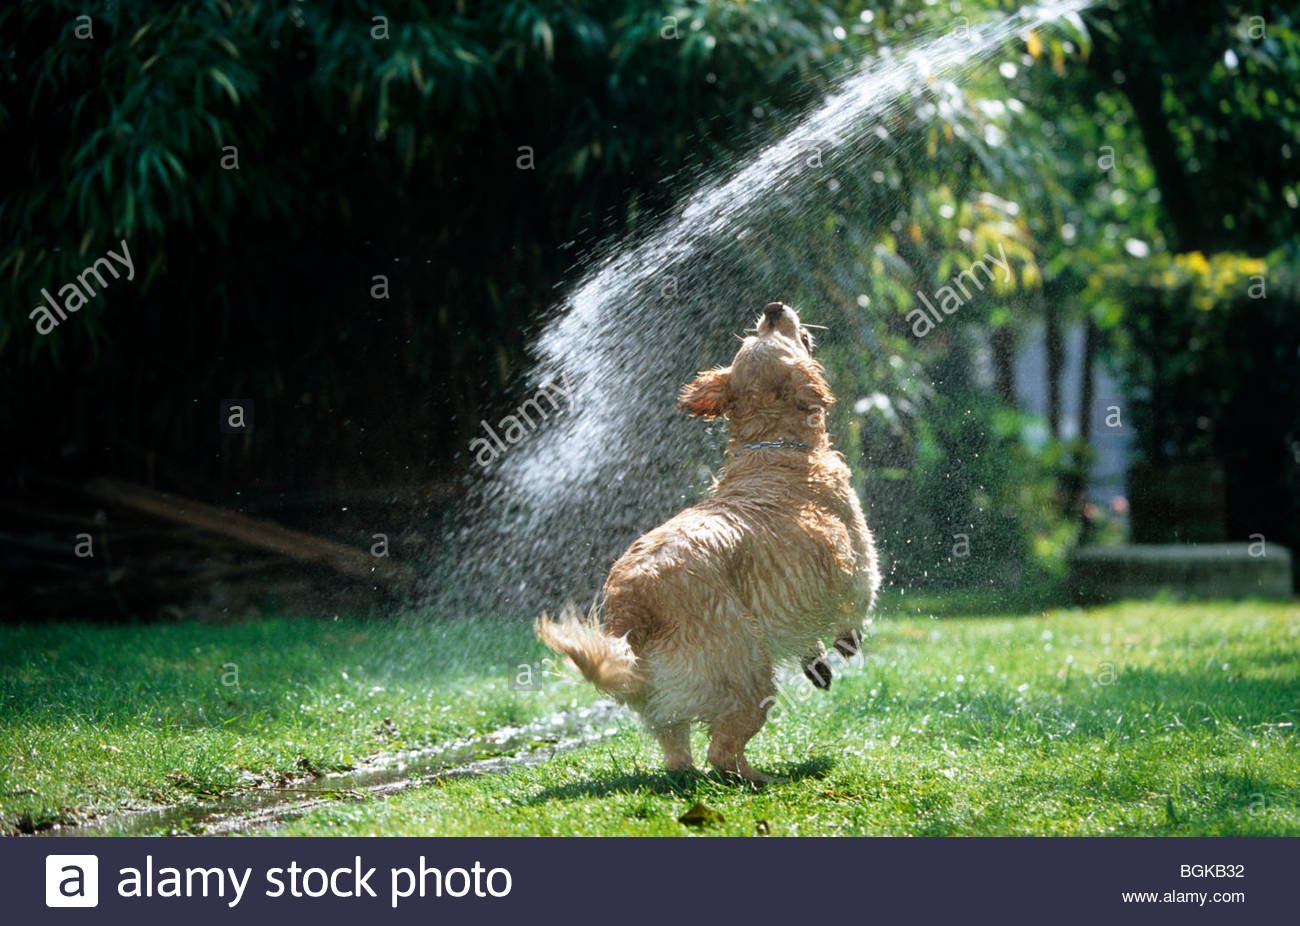

In [86]:
import requests, shutil
from IPython.display import Image,display
# filename = 'Flicker8k_Dataset/3585487286_ef9a8d4c56.jpg' # 1015118661_980735411b.jpg' # 105342180_4d4a40b47f.jpg
imgurl = "https://c8.alamy.com/comp/BGKB32/playful-golden-retriever-dog-playing-with-water-from-garden-hose-BGKB32.jpg"
r = requests.get(imgurl, stream = True)
filename = "testimg.jpg"
if r.status_code == 200:
    # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
    r.raw.decode_content = True    
    # Open a local file with wb ( write binary ) permission.
    with open(filename,'wb') as f:
        shutil.copyfileobj(r.raw, f)

print(get_image_caption(filename,model2))
display(Image(filename))

<b><center> ************* End Of Assignment ************ </b>